# Celebrities

## Dataset

[dataset](https://www.kaggle.com/hereisburak/pins-face-recognition)

## Tips

**Necessary**: [Distutils is deprecated in python 3.12](https://stackoverflow.com/questions/69858963/how-can-one-fully-replace-distutils-which-is-deprecated-in-3-10) so remember to change line 30 of `venv/lib/python3.12/site-packages/tensorflow/__init__.py` from

`import distutils as _distutils`

to

`import setuptools as _distutils`

**Suggestion**: To [enable pylance for tf.keras](https://stackoverflow.com/questions/73496946/vscode-autocomplete-and-suggestion-intellisense-doesnt-work-for-tensorflow-an) in the VSCode add the code below at the end of the file `venv/lib/python3.12/site-packages/tensorflow/__init__.py`

```
if _typing.TYPE_CHECKING:
  from tensorflow_estimator.python.estimator.api._v2 import estimator as estimator
  from keras._tf_keras import keras
  from keras._tf_keras.keras import losses
  from keras._tf_keras.keras import metrics
  from keras._tf_keras.keras import optimizers
  from keras._tf_keras.keras import initializers
```

## How to

decide if you want to load trained model or train it yourself -> set the proper `LOAD_TRAINED_MODEL` value


## Constants

In [43]:
LOAD_TRAINED_MODEL = True
LOAD_TRAINED_WEIGHTS = False

TRAIED_MODELS_PATH = "./trained_models/"
TEST_IMAGES_PATH = "./test_images/"
NAME_105_CLASSES = "105_classes_pins_dataset/"

MODEL_NAME = "my_trained_model_old.keras"
WEIGHTED_NAME = "trained_weights.h5"

## Prepare dataset

In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hereisburak/pins-face-recognition")

print("Path to dataset files:", path)


Path to dataset files: /home/mrrys00/.cache/kagglehub/datasets/hereisburak/pins-face-recognition/versions/1


In [31]:
import os
import pwd

def get_username():
    return pwd.getpwuid(os.getuid())[0]

username = get_username()
work_dir = "/home/" + username + "/.cache/kagglehub/datasets/hereisburak/pins-face-recognition/versions/1"

os.makedirs(TRAIED_MODELS_PATH, exist_ok=True)
os.makedirs(TEST_IMAGES_PATH, exist_ok=True)


In [32]:
train_dir = os.path.join(work_dir, 'train')
test_dir = os.path.join(work_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [33]:
train_ratio = 0.8
test_ratio = 0.2

dir_list = os.listdir(os.path.join(work_dir ,'105_classes_pins_dataset'))

print('The Number of Classes in the Dataset is:{}'.format(len(dir_list)))


The Number of Classes in the Dataset is:105


In [34]:
import numpy as np

from shutil import copyfile

source_dir = os.path.join(work_dir ,'105_classes_pins_dataset')

dir_list = os.listdir(source_dir)

for folder in dir_list:
    data_dir = os.listdir(os.path.join(source_dir,folder))
    np.random.shuffle(data_dir)
    
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, folder), exist_ok=True)
    
    train_data = data_dir[:int(len(data_dir)*train_ratio+1)]
    test_data = data_dir[-int(len(data_dir)*test_ratio):]
  
    for image in train_data:
        copyfile(os.path.join(source_dir,folder,image) , os.path.join(train_dir,folder,image))
    
    for image in test_data:
        copyfile(os.path.join(source_dir,folder,image) , os.path.join(test_dir,folder,image))
    

## Test training

In [35]:
import tensorflow as tf
import keras

# from keras.api.applications import MobileNetV2
# from keras.api.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

rows=160
cols=160


In [36]:
trained_model: tf.keras.applications.MobileNetV2 = MobileNetV2(
    input_shape=(rows,cols,3),           
    include_top=False,
    weights='imagenet')   


trained_model.trainable=True

# trained_model.summary()

In [37]:
last_layer=trained_model.get_layer('out_relu')   
last_layer_output=last_layer.output

In [38]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

## Train main network

In [39]:
from keras.api import Model as keras_model

x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
x = tf.keras.layers.Dropout(0.8)(x)                      
x = tf.keras.layers.Dense(105, activation = 'softmax')(x)

model: keras_model = tf.keras.Model(trained_model.input,x) 

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(1e-4),
    metrics = ['accuracy'])

# model.summary()

In [40]:
train_datagen: tf.keras.preprocessing.image.ImageDataGenerator = ImageDataGenerator(
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1)
                                 
test_datagen: tf.keras.preprocessing.image.ImageDataGenerator = ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(rows,cols),
    class_mode='categorical')

test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(rows,cols),
    class_mode='categorical')

Found 17534 images belonging to 105 classes.
Found 15594 images belonging to 105 classes.


In [28]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(gpus)
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.get_visible_devices()

    try:
        for gpu in gpus:
            print(f'gpu used: {gpu}')
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs")

No GPUs


In [44]:
result = None

if LOAD_TRAINED_MODEL:
    model = tf.keras.models.load_model(f"{TRAIED_MODELS_PATH}{MODEL_NAME}")
elif LOAD_TRAINED_WEIGHTS:
    model.load_weights(f"{TRAIED_MODELS_PATH}{WEIGHTED_NAME}")
else: 
    result = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=100,
        callbacks=[callbacks],
        verbose=1)


/home/mrrys00/University/9.Semestr/Systemy Mobilne/who-is-your-twin-backend/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 160 variables whereas the saved optimizer has 318 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [37]:
if not LOAD_TRAINED_MODEL and not LOAD_TRAINED_WEIGHTS:
    model.save(f"{TRAIED_MODELS_PATH}{MODEL_NAME}")

## Plot training model

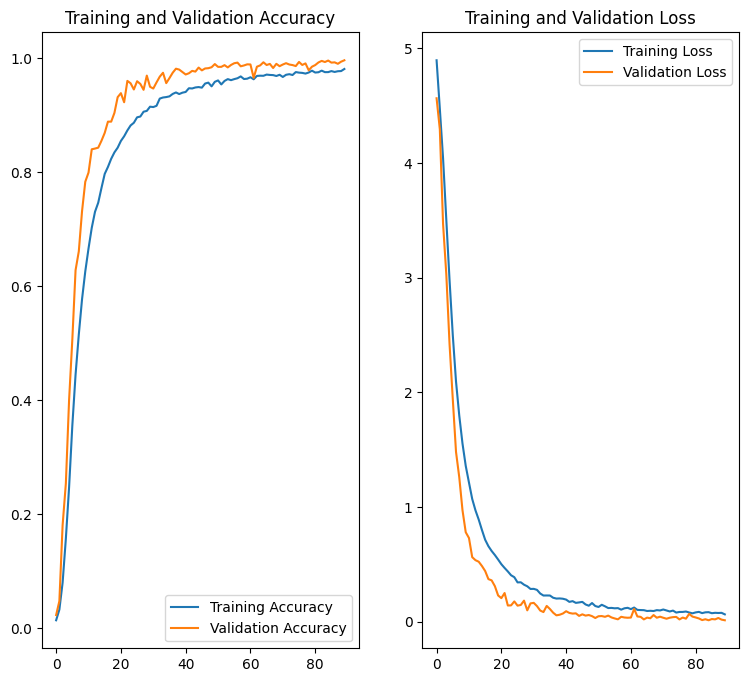

In [41]:
import matplotlib.pyplot as plt

if result is not None:
    acc = result.history['accuracy']
    val_acc = result.history['val_accuracy']

    loss = result.history['loss']
    val_loss = result.history['val_loss']

    epochs_range = range(90)

    plt.figure(figsize=(9, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Show results

In [41]:
import random
from PIL import Image
from IPython.display import display

def show_photo(_name: str) -> None:
    directory = path + "/" + NAME_105_CLASSES + "pins_" + _name
    
    if not os.path.isdir(directory):
        directory = path + "/" + NAME_105_CLASSES + "pins_" + _name.lower()

    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    random_file = random.choice(all_files)

    image_path = os.path.join(directory, random_file)
    image = Image.open(image_path)
    display(image)
    
    return

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
The predicted twin for Piotr-Nawrocki.png is Wentworth Miller.
[(0.994882, 'Wentworth Miller'), (0.0013923344, 'Brian J. Smith'), (0.0009119477, 'Rami Malek'), (0.00086505734, 'Henry Cavil'), (0.00072362326, 'Elon Musk')]


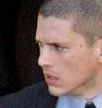

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
The predicted twin for cruise.jpeg is Jimmy Fallon.
[(0.48979282, 'Jimmy Fallon'), (0.1355555, 'Zac Efron'), (0.07465596, 'Alex Lawther'), (0.067938805, 'Chris Hemsworth'), (0.030211294, 'Hugh Jackman')]


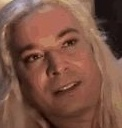

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
The predicted twin for cruise2.jpg is Brenton Thwaites.
[(0.54360014, 'Brenton Thwaites'), (0.107170604, 'Wentworth Miller'), (0.08620108, 'Grant Gustin'), (0.069739334, 'Brian J. Smith'), (0.028966526, 'Rami Malek')]


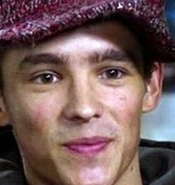

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
The predicted twin for kaenu-reeves.jpeg is Keanu Reeves.
[(0.927679, 'Keanu Reeves'), (0.05407775, 'Robert De Niro'), (0.007037502, 'Tom Ellis'), (0.0044508954, 'Tom Cruise'), (0.0037064767, 'Josh Radnor')]


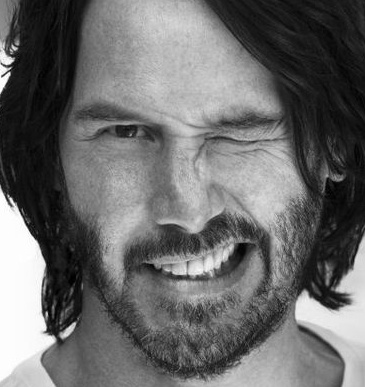

In [46]:
from os import walk

def recognize(_paths: list[str]) -> None:
    classes: dict = train_generator.class_indices
    class_names: list = list(classes.keys())
    
    for _path in _paths:
        img = tf.keras.preprocessing.image.load_img(
            _path, target_size=(rows, cols)
        )

        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)
        img_array=img_array/255.

        score: np.ndarray = model.predict(img_array)

        print(
            f"The predicted twin for {_path[len(TEST_IMAGES_PATH):]} is {class_names[np.argmax(score)][5:].title()}.")
        
        probabilities = [(_sc, class_names[idx][5:].title()) for idx, _sc in enumerate(score[0])]
        probabilities = sorted(probabilities, key=lambda x: x[0], reverse=True)
        print(probabilities[:5])
        
        show_photo(probabilities[0][1])

_paths = next(walk(TEST_IMAGES_PATH), (None, None, []))[2]
_paths = [os.path.join(TEST_IMAGES_PATH, filename) for filename in _paths]

recognize(_paths)